Time series forecasting of fuel price

Training set 2014-2022 (9 years)
Validation set 2023
Test set 2014 Q1

# Data Exploration

In [1]:
# import libraries
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.api import qqplot

from matplotlib import pyplot
from pandas.plotting import lag_plot
import plotly.express as px

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(15,5)})

import xgboost as xgb
from xgboost import plot_importance
from sklearn import metrics 

# Set global style settings
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1  
plt.rcParams['axes.edgecolor'] = 'gray' 

In [2]:
# import data
data_raw = pd.read_excel('data/fuel_types_all.xlsx')
data_raw.tail()

Date  Ottawa  Toronto West/Ouest  Toronto East/Est  Windsor  \
10737 2024-07-02   129.9                77.9              87.9     87.9   
10738 2024-07-08   129.9                77.9              87.9     87.9   
10739 2024-07-15   129.9                77.9              87.9     87.9   
10740 2024-07-22   129.9                77.9              73.9     87.9   
10741 2024-07-29   129.9                77.9              73.9     87.9   

       London  Peterborough  St. Catharine's  Sudbury  Sault Saint Marie  \
10737   105.1           0.0              0.0      0.0                0.0   
10738   105.1           0.0              0.0      0.0                0.0   
10739   105.1           0.0              0.0      0.0                0.0   
10740   105.1           0.0              0.0      0.0                0.0   
10741   105.1           0.0              0.0      0.0                0.0   

       Thunder Bay  North Bay  Timmins  Kenora  Parry Sound  \
10737        119.0        0.0      0.0   120.0          0.0   
10738        119.0        0.0      0.0   120.0          0.0   
10739        119.0        0.0      0.0   120.0          0.0   
10740        119.0        0.0      0.0   120.0          0.0   
10741        119.0        0.0      0.0   120.0          0.0   

       Ontario Average/Moyenne provinciale  \
10737                                 96.0   
10738                                 96.0   
10739                                 96.0   
10740                                 91.7   
10741                                 91.7   

       Southern Average/Moyenne du sud de l'Ontario  \
10737                                          95.0   
10738                                          95.0   
10739                                          95.0   
10740                                          90.5   
10741                                          90.5   

       Northern Average/Moyenne du nord de l'Ontario     Fuel Type  \
10737                                          119.1  Auto Propane   
10738                                          119.1  Auto Propane   
10739                                          119.1  Auto Propane   
10740                                          119.1  Auto Propane   
10741                                          119.1  Auto Propane   

        Type de carburant  
10737  Propane automobile  
10738  Propane automobile  
10739  Propane automobile  
10740  Propane automobile  
10741  Propane automobile

In [3]:
data_raw[data_raw['Ontario Average/Moyenne provinciale'] > .01].min()

Date                                             1990-01-03 00:00:00
Ottawa                                                           0.0
Toronto West/Ouest                                               0.0
Toronto East/Est                                                 0.0
Windsor                                                          0.0
London                                                           0.0
Peterborough                                                     0.0
St. Catharine's                                                  0.0
Sudbury                                                          0.0
Sault Saint Marie                                                0.0
Thunder Bay                                                      0.0
North Bay                                                        0.0
Timmins                                                          0.0
Kenora                                                           0.0
Parry Sound                       

In [4]:
# Obtain right format for date column
data_raw.set_index('Date', inplace=True)
data_raw.index = pd.to_datetime(data_raw.index)
#print(data_raw.info())

In [5]:
data_raw['Fuel Type'].unique()

array(['Regular Unleaded Gasoline', 'Diesel', 'Compressed Natural Gas',
       'Mid-Grade Gasoline', 'Premium Gasoline', 'Auto Propane'],
      dtype=object)

In [6]:
data_raw.describe()

Ottawa  Toronto West/Ouest  Toronto East/Est       Windsor  \
count  10742.000000        10742.000000      10742.000000  10742.000000   
mean      82.634295           80.548352         81.563526     81.474921   
std       41.802555           42.338051         41.019056     39.029077   
min        0.000000            0.000000          0.000000      0.000000   
25%       55.800000           52.500000         53.900000     54.900000   
50%       74.900000           69.900000         70.800000     69.900000   
75%      112.200000          110.900000        111.000000    107.000000   
max      240.800000          240.200000        241.800000    245.600000   

             London  Peterborough  St. Catharine's       Sudbury  \
count  10742.000000  10742.000000     10742.000000  10742.000000   
mean      83.220164     12.654915        12.926382     71.933718   
std       39.624125     42.749957        43.648977     52.982102   
min        0.000000      0.000000         0.000000      0.000000   
25%       55.800000      0.000000         0.000000     39.100000   
50%       76.600000      0.000000         0.000000     67.500000   
75%      109.400000      0.000000         0.000000    112.800000   
max      239.700000    233.600000       239.100000    248.200000   

       Sault Saint Marie   Thunder Bay     North Bay       Timmins  \
count       10742.000000  10742.000000  10742.000000  10742.000000   
mean           79.646267     69.892618     60.689090     63.152225   
std            49.741748     58.870858     59.102686     61.174445   
min             0.000000      0.000000      0.000000      0.000000   
25%            52.600000      0.000000      0.000000      0.000000   
50%            79.000000     74.150000     58.800000     62.400000   
75%           115.200000    119.000000    112.400000    117.800000   
max           244.200000    242.200000    244.100000    244.400000   

             Kenora   Parry Sound  Ontario Average/Moyenne provinciale  \
count  10742.000000  10742.000000                         10742.000000   
mean      15.870052     13.082145                            85.241510   
std       47.778526     44.187874                            37.403298   
min        0.000000      0.000000                             0.000000   
25%        0.000000      0.000000                            57.200000   
50%        0.000000      0.000000                            73.000000   
75%        0.000000      0.000000                           110.800000   
max      243.000000    239.800000                           239.600000   

       Southern Average/Moyenne du sud de l'Ontario  \
count                                  10742.000000   
mean                                      74.433122   
std                                       48.418853   
min                                        0.000000   
25%                                       49.600000   
50%                                       67.400000   
75%                                      110.200000   
max                                      240.300000   

       Northern Average/Moyenne du nord de l'Ontario  
count                                   10742.000000  
mean                                       80.669019  
std                                        49.272920  
min                                         0.000000  
25%                                        54.100000  
50%                                        80.400000  
75%                                       116.900000  
max                                       241.100000

In [7]:
# Average fuel price based on fuel type
print('Avg price', data_raw['Ontario Average/Moyenne provinciale'].mean())
print('Min price', data_raw['Ontario Average/Moyenne provinciale'].min())
print('Max price', data_raw['Ontario Average/Moyenne provinciale'].max())


a = data_raw[data_raw['Fuel Type']=='Regular Unleaded Gasoline']['Ontario Average/Moyenne provinciale'].mean() 
b= data_raw[data_raw['Fuel Type']=='Diesel']['Ontario Average/Moyenne provinciale'].mean() 
c=data_raw[data_raw['Fuel Type']=='Compressed Natural Gas']['Ontario Average/Moyenne provinciale'].mean() 
d=data_raw[data_raw['Fuel Type']=='Mid-Grade Gasoline']['Ontario Average/Moyenne provinciale'].mean() 
e=data_raw[data_raw['Fuel Type']=='Premium Gasoline']['Ontario Average/Moyenne provinciale'].mean() 
f=data_raw[data_raw['Fuel Type']=='Auto Propane']['Ontario Average/Moyenne provinciale'].mean() 
print(a,b,c,d,e,f)
#df[df["col1"]==entry]["col2"].mean()

Avg price 85.24150996090114
Min price 0.0
Max price 239.6
92.39091412742383 92.12382271468144 64.54245777518928 100.6784487534626 105.70509695290859 54.99916897506925


In [8]:
# Extract required data only
# Response variable, y = Fuel price in Ontario (all other columns are redundant for our time series forecasting
processed_data = pd.DataFrame()
# +++ Change target value
processed_data['fuel_price'] = data_raw['Ontario Average/Moyenne provinciale'].copy() # Ontario Average/Moyenne provinciale
# withtout copy, all operations of dataframe will be in-place (which is not a good practise from data science perspective)
processed_data['fuel_type'] = data_raw['Fuel Type'].copy() # withtout copy, all operations of dataframe will be in-place (which is not a good practise from data science perspective)


processed_data = processed_data[processed_data['fuel_type'] == 'Regular Unleaded Gasoline'] 
# 'Regular Unleaded Gasoline', 'Diesel', 'Compressed Natural Gas', 'Mid-Grade Gasoline', 'Premium Gasoline', 'Auto Propane'
processed_data = processed_data[processed_data.index > '01-01-2014']
processed_data = processed_data.drop('fuel_type', axis=1)
# df.loc[(df['col1'] == value) & (df['col2'] < value)]
#input_data[df.fuel_price > 10]
display(processed_data)

fuel_price
Date                  
2014-01-06       125.3
2014-01-13       126.4
2014-01-20       125.7
2014-01-27       126.5
2014-02-03       127.3
...                ...
2024-07-02       165.2
2024-07-08       166.9
2024-07-15       166.0
2024-07-22       165.2
2024-07-29       166.8

[552 rows x 1 columns]

In [9]:
# dramatic variation from 2020 - 2023 


## Fuel Price Fig4

In [10]:
## Create subset of data for latest 5 years
data_2014_2023 = data_raw[data_raw.index > '01-01-2014']
data_2014_2023.to_excel('data/data_2014_2023.xlsx')

In [11]:
display(data_2014_2023)

Ottawa  Toronto West/Ouest  Toronto East/Est  Windsor  London  \
Date                                                                        
2014-01-06   123.5               124.6             124.8    127.5   122.2   
2014-01-13   124.8               126.7             126.5    122.8   123.1   
2014-01-20   124.2               125.9             125.6    120.7   123.4   
2014-01-27   125.1               126.9             126.7    120.3   124.2   
2014-02-03   126.2               127.3             127.3    124.1   125.2   
...            ...                 ...               ...      ...     ...   
2024-07-02   129.9                77.9              87.9     87.9   105.1   
2024-07-08   129.9                77.9              87.9     87.9   105.1   
2024-07-15   129.9                77.9              87.9     87.9   105.1   
2024-07-22   129.9                77.9              73.9     87.9   105.1   
2024-07-29   129.9                77.9              73.9     87.9   105.1   

            Peterborough  St. Catharine's  Sudbury  Sault Saint Marie  \
Date                                                                    
2014-01-06           0.0              0.0    134.6              133.9   
2014-01-13           0.0              0.0    132.6              133.9   
2014-01-20           0.0              0.0    131.7              133.9   
2014-01-27           0.0              0.0    132.6              133.9   
2014-02-03           0.0              0.0    132.6              133.9   
...                  ...              ...      ...                ...   
2024-07-02           0.0              0.0      0.0                0.0   
2024-07-08           0.0              0.0      0.0                0.0   
2024-07-15           0.0              0.0      0.0                0.0   
2024-07-22           0.0              0.0      0.0                0.0   
2024-07-29           0.0              0.0      0.0                0.0   

            Thunder Bay  North Bay  Timmins  Kenora  Parry Sound  \
Date                                                               
2014-01-06        130.7      128.1    138.7     0.0          0.0   
2014-01-13        130.7      126.6    138.8     0.0          0.0   
2014-01-20        130.7      126.0    138.7     0.0          0.0   
2014-01-27        130.7      126.6    138.7     0.0          0.0   
2014-02-03        130.7      125.3    138.7     0.0          0.0   
...                 ...        ...      ...     ...          ...   
2024-07-02        119.0        0.0      0.0   120.0          0.0   
2024-07-08        119.0        0.0      0.0   120.0          0.0   
2024-07-15        119.0        0.0      0.0   120.0          0.0   
2024-07-22        119.0        0.0      0.0   120.0          0.0   
2024-07-29        119.0        0.0      0.0   120.0          0.0   

            Ontario Average/Moyenne provinciale  \
Date                                              
2014-01-06                                125.3   
2014-01-13                                126.4   
2014-01-20                                125.7   
2014-01-27                                126.5   
2014-02-03                                127.3   
...                                         ...   
2024-07-02                                 96.0   
2024-07-08                                 96.0   
2024-07-15                                 96.0   
2024-07-22                                 91.7   
2024-07-29                                 91.7   

            Southern Average/Moyenne du sud de l'Ontario  \
Date                                                       
2014-01-06                                         124.4   
2014-01-13                                         125.7   
2014-01-20                                         124.9   
2014-01-27                                         125.8   
2014-02-03                                         126.7   
...                                                  ...   
2024-07-02                     

### Fig4a by location


In [ ]:
df_location = data_2014_2023.groupby(pd.Grouper(freq="Y")) 
data_2014_2023.columns
#df_location.head()
data0 = data_2014_2023.drop(['Fuel Type', 'Type de carburant'], axis=1)
data2 = data0.groupby([(data_2014_2023.index.year)]).mean()
data2.columns

df_location = data2[['Ottawa', 'Toronto West/Ouest', 'Toronto East/Est', 'Windsor',
       'London', 'Peterborough', "St. Catharine's", 'Sudbury',
       'Sault Saint Marie', 'Thunder Bay', 'North Bay', 'Timmins', 'Kenora',
       'Parry Sound']]
df_location

In [ ]:
%matplotlib widget

df_location2 = df_location.replace(0, np.nan, inplace=False)
plt.rcParams["figure.figsize"] = [5, 8]
df_location2.plot(colormap='tab20c') # no colormap  bwr

plt.ylabel('Fuel Price in CAD')
plt.legend(bbox_to_anchor=(0.5, -0.2))
plt.tight_layout()
plt.savefig('figs/location-wise price.png')
plt.show()
# https://matplotlib.org/stable/users/explain/colors/colormaps.html

### Fig4b by Fuel type

In [ ]:
data_priceVsType = data_raw[['Ontario Average/Moyenne provinciale', 'Fuel Type']].reset_index() #.to_csv('data.csv')
legend1 = list(data_priceVsType['Fuel Type'].unique())

fg = sns.FacetGrid(data=data_priceVsType, hue='Fuel Type', height=3.5, aspect=3)
fg.map(plt.scatter, 'Date', 'Ontario Average/Moyenne provinciale', alpha=0.1).add_legend()
fg.savefig('figs/fuelType_vs_price.png')
#ax.scatter(data = data_priceVsType, x= 'Date', y='Ontario Average/Moyenne provinciale', 
#           c='Fuel Type')
# average price
# This section should be moved to EDA section, but putting it here to maintain chronology with the technical report 
data_priceVsType['Fuel Type'].unique()
data_priceVsType.columns

## Assumptions

### Monthly pattern: Fig5a

/var/folders/xd/bkg103js7ms2lvxxhsmqkz5r0000gn/T/ipykernel_870/3900523125.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


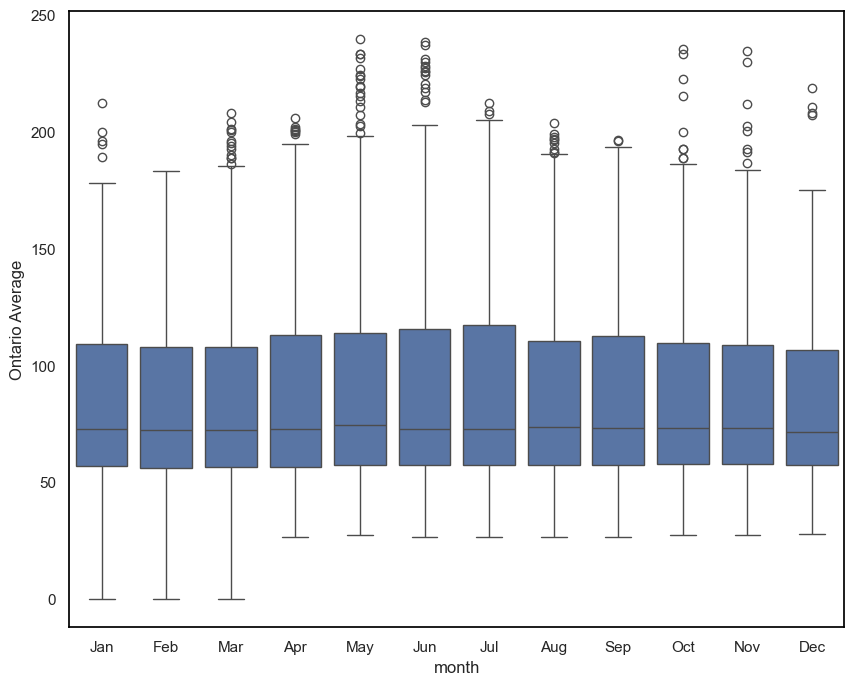

In [23]:

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=data, x='month', y='Ontario Average/Moyenne provinciale') # Fuel prices in Ontario
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Ontario Average')
plt.savefig('figs/monthly_fuel_price_variation.png')
plt.show()
# in last 10 years, no noteworthy price fluctuation in certain month of year, 
# there are some anamoly in 4th quarter of year though.

### Lag Behavior: Fig5b

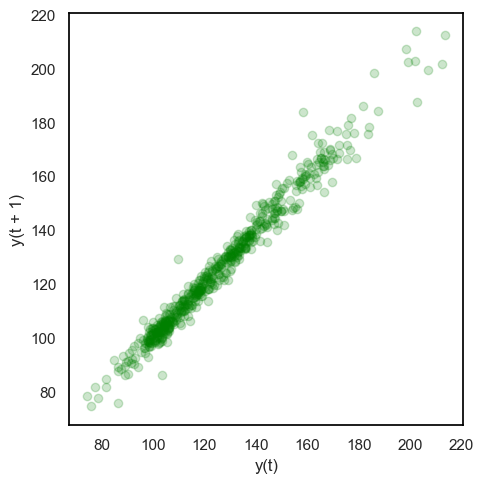

In [12]:
fig, ax = plt.subplots(figsize=(5,5))
lag_plot(processed_data, alpha=0.2, c='green')
plt.tight_layout()
plt.savefig('figs/seasonality_scatterplot.png')
pyplot.show()

### ACP & PACP: Fig5(c,d)

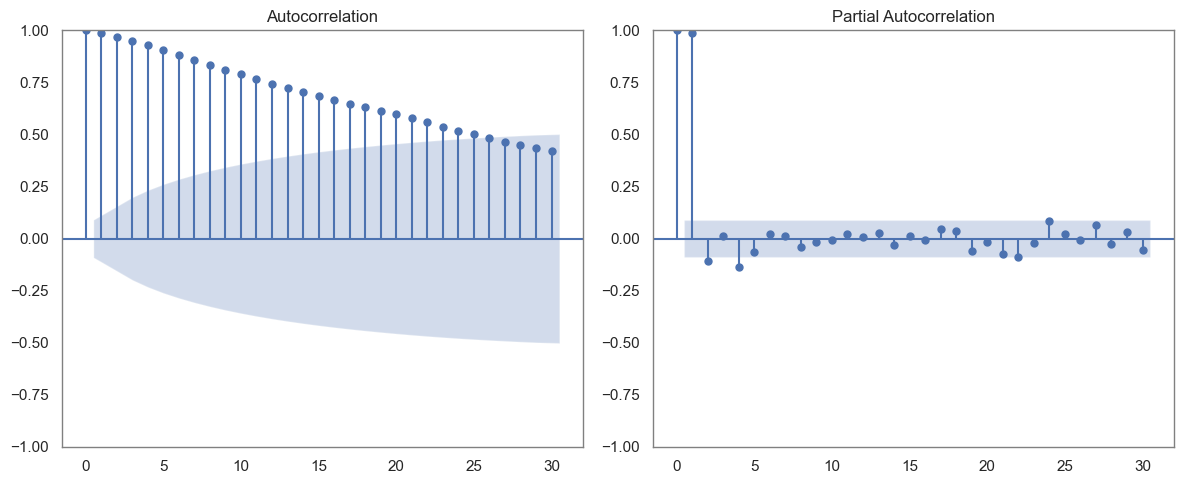

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess

# Generate synthetic time series data (ARMA process)
np.random.seed(42)
ar = np.array([1, -0.5])  # AR(1) with a coefficient of -0.5
ma = np.array([1, 0.5])   # MA(1) with a coefficient of 0.5
arma_process = ArmaProcess(ar, ma)

# Convert to a pandas series
time_series = y_train

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF plot
plot_acf(time_series, lags=30, ax=axes[0])
#axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(time_series, lags=30, ax=axes[1])
#axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.savefig('figs/ACP_PACP.png', dpi=400)
plt.show()


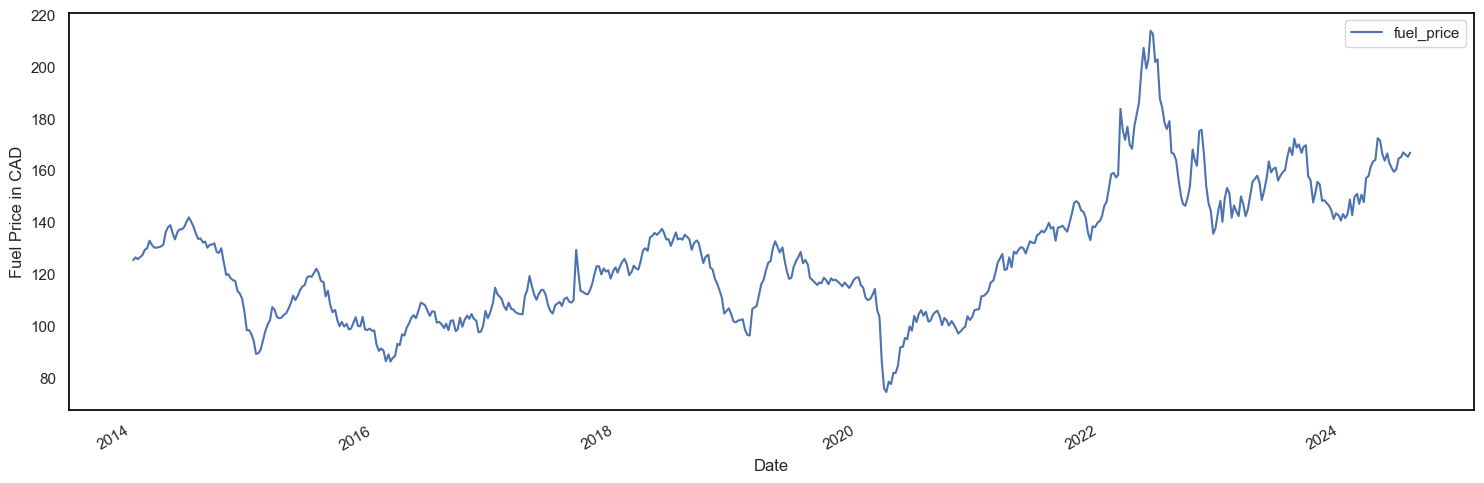

In [13]:
processed_data.plot(figsize=(15,5))
plt.ylabel('Fuel Price in CAD')

plt.tight_layout()
plt.savefig('figs/time_series.png')
plt.show()

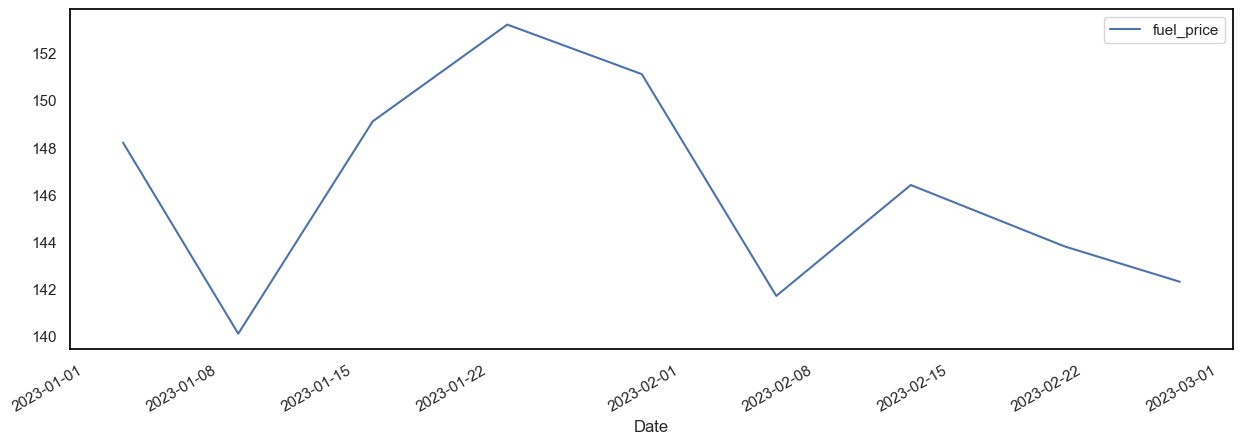

In [15]:
processed_data.loc[(processed_data.index > '01-01-2023') & (processed_data.index < '3-01-2023')] \
    .plot(figsize=(15, 5))
plt.savefig('figs/macro-analysis of price Jan-Mar2023.png')
plt.show()

### Seasonal decompostion: Fig6

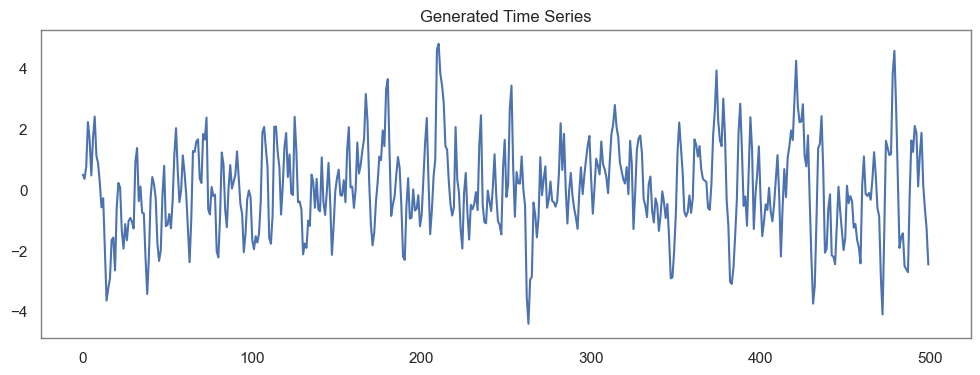

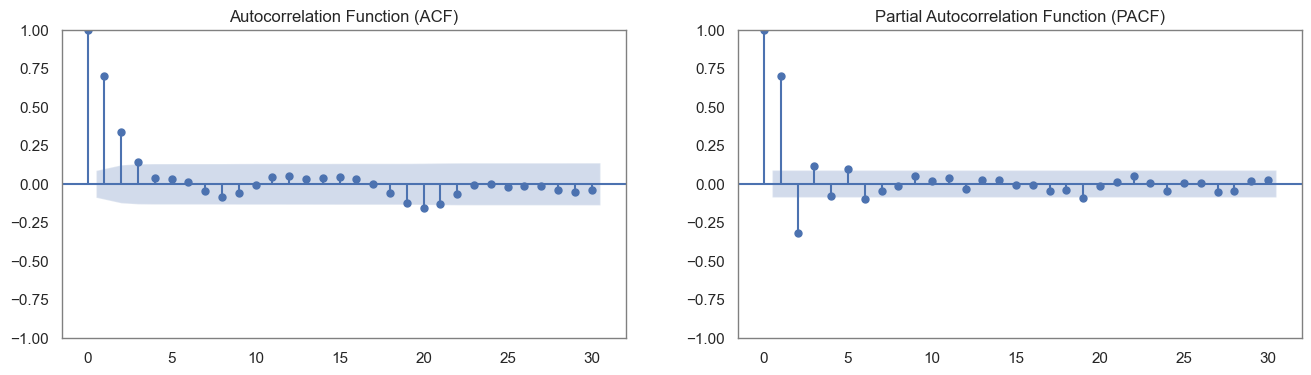

In [66]:
decompose_result_mult = seasonal_decompose(processed_data, model="additive",
                                           period=int(len(processed_data) / 10))

#trend = decompose_result_mult.trend
#seasonal = decompose_result_mult.seasonal
#residual = decompose_result_mult.resid
#fig, ax = plt.subplots(figsize=(10,5))
decompose_result_mult.plot()
plt.savefig('figs/seasonality.png')

## Feature Engineering

In [17]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

data = create_features(data_raw)

In [18]:
train_raw = processed_data.loc[processed_data.index < '01-07-2023']  #  and 
validation_raw = processed_data[(processed_data.index >= '01-01-2023') & (processed_data.index <= '31-12-2023')]
test_raw = processed_data[(processed_data.index >= '01-01-2024') & (processed_data.index <= '31-03-2024')]
# df[(df['Date'] > start_date) & (df['Date'] < end_date)]
processed_data.tail(10)

fuel_price
Date                  
2024-05-27       162.8
2024-06-03       160.9
2024-06-10       159.4
2024-06-17       160.3
2024-06-24       164.5
2024-07-02       165.2
2024-07-08       166.9
2024-07-15       166.0
2024-07-22       165.2
2024-07-29       166.8

In [19]:
train = create_features(train_raw)
validation = create_features(validation_raw)
test = create_features(test_raw)

xs = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
X_train = train[xs]
X_validation = validation[xs]
X_test = test[xs]

y_train = train['fuel_price'].values
y_validation = validation['fuel_price'].values
y_test = test['fuel_price'].values 

# Modeling

## ARIMA

In [38]:
model_arima = ARIMA(processed_data, order=(3, 0, 0)) #.fit() X_train
model_arima_fit = model_arima.fit()

/Users/tanmoydas/Applications/anaconda3/envs/Freelancing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanmoydas/Applications/anaconda3/envs/Freelancing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/tanmoydas/Applications/anaconda3/envs/Freelancing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
print(model_arima_fit.params)
resid = model_arima_fit.resid

const     130.235261
ar.L1       1.066879
ar.L2      -0.082016
ar.L3       0.002554
sigma2     14.622103
dtype: float64


### ARIMA model statistics: Table4

In [40]:
print(model_arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             fuel_price   No. Observations:                  552
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -1525.521
Date:                Fri, 09 Aug 2024   AIC                           3061.043
Time:                        15:41:33   BIC                           3082.610
Sample:                             0   HQIC                          3069.470
                                - 552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        130.2353     14.016      9.292      0.000     102.765     157.705
ar.L1          1.0669      0.031     34.719      0.000       1.007       1.127
ar.L2         -0.0820      0.047     -1.739      0.0

### QQ Plot: Fig 10a

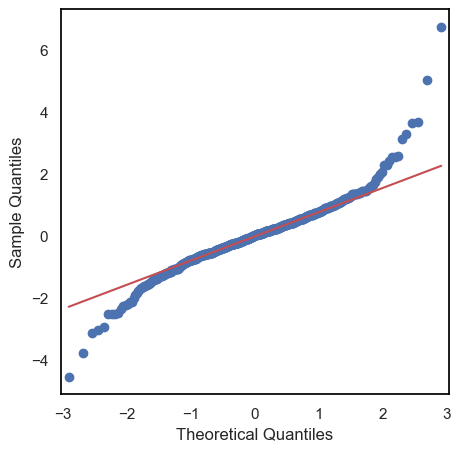

In [41]:
# Checking normality assumption
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
fig = qqplot(resid, line="q", ax=ax, fit=True)
plt.savefig('figs/qqplot.png')

In [42]:
y_pred_arima = model_arima_fit.predict(start=1, end=521, exog=None, dynamic=False)
type(y_pred_arima)#.shape

pandas.core.series.Series

In [43]:
display(y_pred_arima)

y_pred_a = y_pred_arima.values[471:521] #y_test.shape

Date
2014-01-13    125.357689
2014-01-20    126.535607
2014-01-27    125.698638
2014-02-03    126.612361
2014-02-10    127.398464
                 ...    
2023-12-04    146.021191
2023-12-11    144.180016
2023-12-18    140.804391
2023-12-27    143.417582
2024-01-02    142.161841
Name: predicted_mean, Length: 521, dtype: float64

In [44]:
# Future data
X_future_raw = pd.DataFrame({'Date':pd.date_range(start='2024-01-01', periods=91)})
X_future_raw.set_index('Date', inplace=True)
X_future_raw.index = pd.to_datetime(X_future_raw.index)

X_future2 = create_features(X_future_raw)
xs = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']
X_future = X_future2[xs]
X_future.index.unique()

monday = X_future[X_future.index.weekday==0]

In [45]:
y_pred_future = model_arima_fit.forecast(13)#[0]
y_pred_future.index = monday.index
y_pred_future
#yhat2 = model_arima_fit.forecast('2024Q1')
# https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_forecasting.html

/Users/tanmoydas/Applications/anaconda3/envs/Freelancing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/tanmoydas/Applications/anaconda3/envs/Freelancing/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Date
2024-01-01    166.469060
2024-01-08    165.982718
2024-01-15    165.495078
2024-01-22    165.013868
2024-01-29    164.539228
2024-02-05    164.071066
2024-02-12    163.609294
2024-02-19    163.153823
2024-02-26    162.704569
2024-03-04    162.261445
2024-03-11    161.824370
2024-03-18    161.393259
2024-03-25    160.968032
Name: predicted_mean, dtype: float64

In [46]:
rmse_score = np.sqrt(metrics.root_mean_squared_error(test['fuel_price'], y_pred_a))
mae_score = np.sqrt(metrics.mean_absolute_error(test['fuel_price'], y_pred_a))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')
print(f'MAE Score on Test set: {mae_score:0.2f}')
# https://scikit-learn.org/stable/modules/model_evaluation.html

ValueError: Found input variables with inconsistent numbers of samples: [13, 50]

In [0]:
processed_data.tail()
y_pred_arima.index = processed_data.index

### Time series plots (actual vs predicted)

In [0]:
fig, ax = plt.subplots(figsize=(15,5))
ax = y_pred_arima.plot(color='black', alpha=0.4,  lw=2, label='predicted')
processed_data.plot(ax=ax, color='green',alpha=0.4, ls='--', label='original')
y_pred_future.plot(ax=ax, color='red', label='future forecasting')

plt.tight_layout()
plt.savefig('figs/time_serise_forecast.png')
plt.show()

## XGBoost

In [24]:
model_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=10,
                       early_stopping_rounds=5,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.1)

model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:110.61574	validation_1-rmse:130.86195
[9]	validation_0-rmse:44.73712	validation_1-rmse:42.32027


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Hyperparam tuning

In [25]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]


for l in learning_rate:
    model_xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=20,
                       learning_rate=l)
    print(l)
    model_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)
    
    

0.0001
[0]	validation_0-rmse:122.58988	validation_1-rmse:147.30218
[100]	validation_0-rmse:121.39644	validation_1-rmse:145.66452
[200]	validation_0-rmse:120.21494	validation_1-rmse:144.04288
[300]	validation_0-rmse:119.04526	validation_1-rmse:142.43710
[400]	validation_0-rmse:117.88725	validation_1-rmse:140.84703
[500]	validation_0-rmse:116.74081	validation_1-rmse:139.27252
[600]	validation_0-rmse:115.60582	validation_1-rmse:137.71341
[700]	validation_0-rmse:114.48217	validation_1-rmse:136.16955
[800]	validation_0-rmse:113.36975	validation_1-rmse:134.64081
[900]	validation_0-rmse:112.26841	validation_1-rmse:133.12703
[999]	validation_0-rmse:111.18829	validation_1-rmse:131.64296
0.001
[0]	validation_0-rmse:122.48192	validation_1-rmse:147.15405
[100]	validation_0-rmse:111.07496	validation_1-rmse:131.48720
[200]	validation_0-rmse:100.74871	validation_1-rmse:117.28829
[300]	validation_0-rmse:91.40470	validation_1-rmse:104.42046
[400]	validation_0-rmse:82.95169	validation_1-rmse:92.75968
[5

In [26]:
# Remove manual values (extract from previous code cell ++) 
error_df = pd.DataFrame([[0.0001, 0,	122.65556],
[0.0001, 100, 121.46165	],
[0.0001, 200,	120.27970],
[0.0001, 300, 119.10958],
[0.0001, 400, 117.95117],
[0.0001, 500,116.80437],
[0.0001, 600, 115.66906],
[0.0001, 700, 114.54513],
[0.0001, 800, 113.43247],
[0.0001, 900, 112.33093	],
[0.0001, 999, 111.25123	],


[0.001, 0, 	122.54756],
[0.001, 100,111.13788	],
[0.001, 200,100.81944	],
[0.001, 300,91.48905	],
[0.001, 400,83.05499	],
[0.001, 500,75.43433	],
[0.001, 600,68.54380	],
[0.001, 700,62.31813	],
[0.001, 800,56.69320	],
[0.001, 900,51.60123	],
[0.001, 999,47.04521	],


[0.01, 0, 121.46765	],
[0.01, 100, 46.41497	],
[0.01, 200, 19.50075	],
[0.01, 295, 10.85637	],

[0.1, 0, 110.67810	],
[0.1, 72, 5.97429	],

[0.2, 0, 98.71501	],
[0.2, 60, 4.64358	],

[0.3, 0, 86.78917	],
[0.3, 55, 3.78368	]])

error_df.columns = ['Learning Rate', '# Estimator', 'RMSE']
#error_df.info()
# +++
# y_pred = 200; RMSE = 20 RMSE 2% 


### Error curve: Fig7

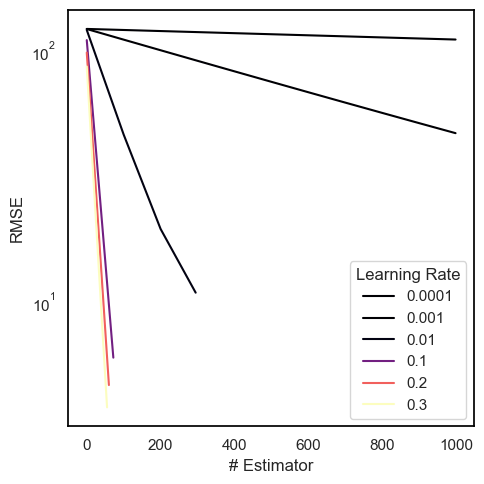

In [27]:
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(data=error_df, x="# Estimator", y="RMSE", hue="Learning Rate", palette='magma')
plt.yscale('log')
plt.tight_layout()
plt.savefig('figs/error_a.png')

In [28]:
error_df2 = pd.DataFrame([
[0.001, 0, 	122.54756, 153],
[0.001, 100,111.13788	, 138],
[0.001, 200,100.81944	, 124],
[0.001, 300,91.48905	, 111],
[0.001, 400,83.05499	,99],
[0.001, 500,75.43433	,88],
[0.001, 600,68.54380	,79],
[0.001, 700,62.31813	,70],
[0.001, 800,56.69320	,63],
[0.001, 900,51.60123	,56],
[0.001, 999,47.04521	,49]])
error_df2.columns = ['Learning Rate', '# Estimator', 'Training Error', 'Test Error']

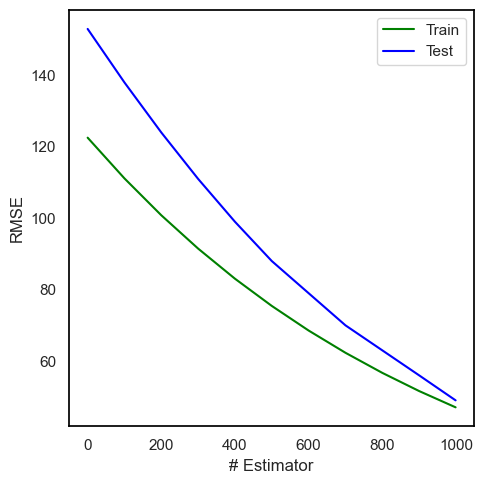

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
sns.lineplot(data=error_df2, x="# Estimator", y='Training Error', label='Train', c='green')
sns.lineplot(data=error_df2, x="# Estimator", y='Test Error', label='Test', c='blue')

#plt.legend(loc='upper right', labels=['Test error'])
#ax.legend()
plt.ylabel('RMSE')

plt.tight_layout()
plt.savefig('figs/error_b.png')
plt.show()

In [32]:
y_pred = model_xgb.predict(X_test)
rmse_score = np.sqrt(metrics.root_mean_squared_error(test['fuel_price'], y_pred))
mae_score = np.sqrt(metrics.mean_absolute_error(test['fuel_price'], y_pred))
print(f'RMSE Score on Test set: {rmse_score:0.2f}')
print(f'MAE Score on Test set: {mae_score:0.2f}')
# https://scikit-learn.org/stable/modules/model_evaluation.html

RMSE Score on Test set: 2.59
MAE Score on Test set: 2.45


In [34]:
model_xgb.feature_importances_

array([0.01902811, 0.00663529, 0.43402678, 0.01882367, 0.5214861 ],
      dtype=float32)

### Important variables: Fig 10b

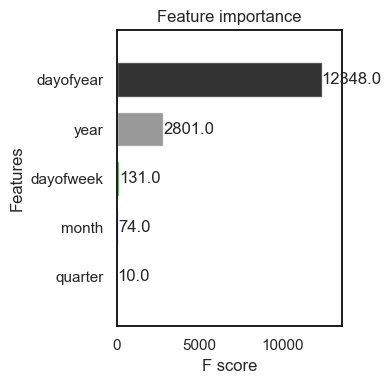

In [36]:
plt.rcParams["figure.figsize"] = (4, 4)
plot_importance(model_xgb, color=['red', 'blue', 'green','gray', 'black'], alpha=0.8, height=0.7)
plt.tight_layout()
plt.savefig('figs/feature_importance.png')
plt.show()
# https://xgboost.readthedocs.io/en/stable/python/python_api.html

## ACO

## ACO-XGBoost
Ant Colony Optimization for Hyperparam tuing

### ACO-XGBoost 1

In [48]:
# Example usage:
# Assuming X_train, X_test, y_train, y_test are defined and loaded
from src.ACO_XGBoost_1 import AntColonyOptimizer
from sklearn.metrics import root_mean_squared_error

num_ants = 10
num_iterations = 20
evaporation_rate = 0.2
pheromone_deposition_rate = 0.5

hyperparameter_ranges = {
    'n_estimators': (500, 2000),
    'max_depth': (20, 40),
    'learning_rate': (0.0001, 0.003)
}

aco = AntColonyOptimizer(num_ants, num_iterations, evaporation_rate, pheromone_deposition_rate, hyperparameter_ranges)

# Optimize hyperparameters
best_params, best_score = aco.optimize(X_train, y_train, X_test, y_test)

print('best_params:', best_params)
print('best_score:', best_score)

KeyboardInterrupt: 

In [49]:
# Train final model with best parameters
from xgboost import XGBRegressor
ACO_XGBoost = XGBRegressor(
    n_estimators=int(best_params['n_estimators']),
    max_depth=int(best_params['max_depth']),
    learning_rate=best_params['learning_rate']
)
ACO_XGBoost.fit(X_train, y_train)

# Predict and evaluate
predictions = ACO_XGBoost.predict(X_test)
rmse = root_mean_squared_error(y_test, predictions)
print('Root Mean Squared Error:', rmse)

NameError: name 'best_params' is not defined

### ACO-XGBoost 2

In [ ]:
## Summary statistics
import pandas as pd
evaporation_rate = 0.2
lags = 4

# Summary data
summary_data = {
    'Metric': [
        'Dataset Size',
        'Training Set Size',
        'Test Set Size',
        'Number of Features',
        'Lag Features',
        'Number of Ants',
        'Number of Iterations',
        'Evaporation Rate',
        'Best n_estimators',
        'Best max_depth',
        'Best learning_rate',
        'Root Mean Squared Error'
    ],
    'Value': [
        len(data),
        len(X_train),
        len(X_test),
        X_train.shape[1],
        lags,
        num_ants,
        num_iterations,
        evaporation_rate,
        best_params['n_estimators'],
        best_params['max_depth'],
        best_params['learning_rate'],
        rmse
    ]
}

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print(summary_df)


In [ ]:
summary_data

### Best Cost vs iteration: Fig8

Generation 1: Best Cost = 0.10026889134517265
Generation 2: Best Cost = 0.08102584854465132
Generation 3: Best Cost = 0.08102584854465132
Generation 4: Best Cost = 0.08102584854465132
Generation 5: Best Cost = 0.08099480801327467
Generation 6: Best Cost = 0.08099480801327467
Generation 7: Best Cost = 0.08099480801327467
Generation 8: Best Cost = 0.08099480801327467
Generation 9: Best Cost = 0.08099480801327467
Generation 10: Best Cost = 0.08099480801327467


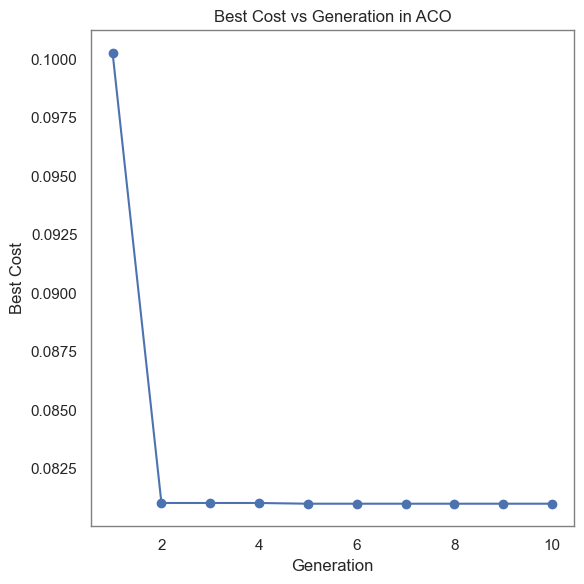

In [72]:
# Example usage
from src.best_cost_vs_iteration import Ant, ACOOptimizer
param_space = {
    'n_estimators': [50, 100, 500],
    'max_depth': [3, 5, 20],
    'learning_rate': [0.0001, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

X = np.random.rand(100, 10)  # Example feature set
y = np.random.rand(100)  # Example target variable

optimizer = ACOOptimizer(param_space, num_ants=5, num_generations=10)
optimizer.optimize(X, y)
optimizer.plot_cost_vs_generation()
# replace data with our data ++ 

### ACO-XGBoost model prediction: Fig9

In [82]:
from src.time_series_plotter import TimeSeriesPlotter
from sklearn.utils import resample
from xgboost import XGBRegressor

# Example usage:
time = test_raw.index#[np.arange(0, 100), np.arange(0, 100)]
actual = y_test #[np.sin(0.1 * np.arange(0, 100)), np.cos(0.1 * np.arange(0, 100))]

# Train final model with best parameters
ACO_XGBoost = XGBRegressor(
    n_estimators=20,
    max_depth=10,
    learning_rate=0.0001
)
ACO_XGBoost.fit(X_train, y_train)

y_pred_validation = ACO_XGBoost.predict(X_validation)


# Step 2: Bootstrap resampling and making predictions
n_bootstraps = 100  # Number of bootstrap samples
predictions = np.zeros((n_bootstraps, len(X_test)))

for i in range(n_bootstraps):
    # Resample the data
    X_resampled, y_resampled = resample(X_train, y_train)
    
    # Fit the model on resampled data
    xgboost_model_resampled = xgb.XGBRegressor()
    xgboost_model_resampled.fit(X_resampled, y_resampled)
    
    # Predict on the test data
    predictions[i, :] = xgboost_model_resampled.predict(X_test)

# Step 3: Calculate the prediction intervals
lower_bound = np.percentile(predictions, 2.5, axis=0)
upper_bound = np.percentile(predictions, 97.5, axis=0)
mean_prediction = np.mean(predictions, axis=0)

#plotter = TimeSeriesPlotter(time, actual, mean_prediction, lower_bound, upper_bound)
#plotter.plot(['Series 1', 'Series 2'])


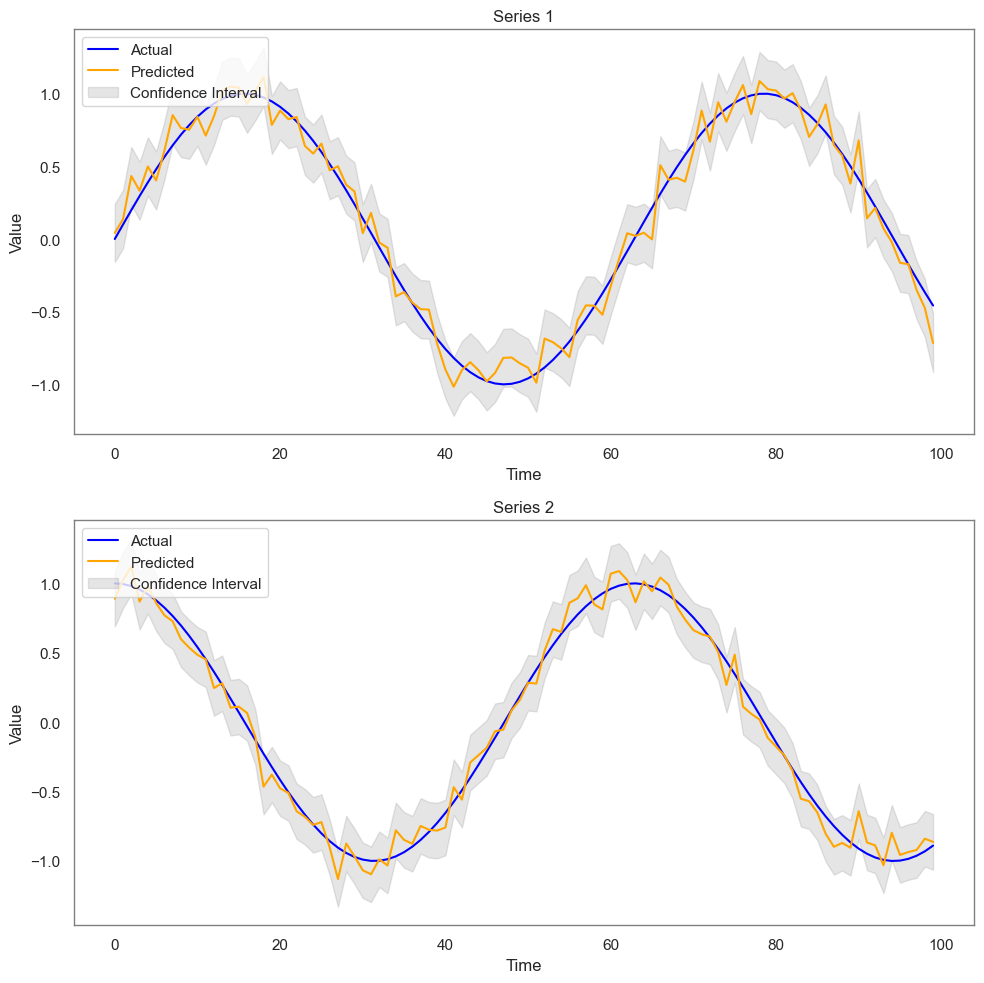

In [83]:
# Example usage:
from src.time_series_plotter import TimeSeriesPlotter
time = [np.arange(0, 100), np.arange(0, 100)]
actual = [np.sin(0.1 * np.arange(0, 100)), np.cos(0.1 * np.arange(0, 100))]
predicted = [np.sin(0.1 * np.arange(0, 100)) + 0.1 * np.random.randn(100),
             np.cos(0.1 * np.arange(0, 100)) + 0.1 * np.random.randn(100)]
lower_ci = [predicted[0] - 0.2, predicted[1] - 0.2]
upper_ci = [predicted[0] + 0.2, predicted[1] + 0.2]

plotter = TimeSeriesPlotter(time, actual, predicted, lower_ci, upper_ci)
plotter.plot(['Series 1', 'Series 2'])


In [88]:
import plotly.graph_objects as go
y_future = model_xgb.predict(X_future)


data_future = pd.DataFrame()
data_future.index = X_future.index
data_future['y_future'] = y_future

data_future2 = data_future.reset_index()


fig = px.line(data_future2, x='Date', y='y_future', render_mode='webg1')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="3m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(step="all")
        ])
    )
)
fig.show()
plt.savefig('figs/inter.png')
# need to fix x axis value+++ 

<Figure size 400x400 with 0 Axes>

# Model validation and model selection

## Performance of different models: Table7

## Forecasting and CI on Test data: Fig11 

ConversionError: Failed to convert value(s) to axis units: '01-01-2024'

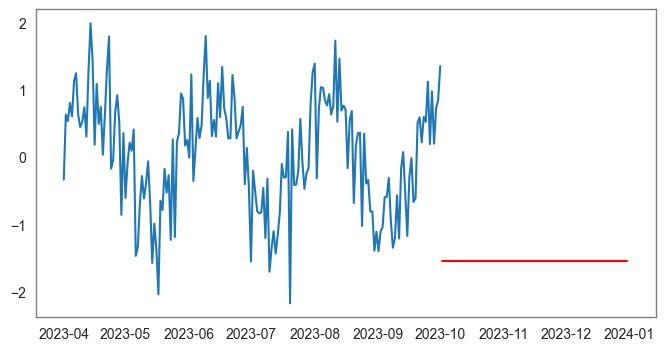

In [2]:
# Example usage:
# Assuming you have a DataFrame `df` with a DateTime index and a 'Value' column
from src.forecasting_plot import ForecastingPLot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.linewidth'] = 1  
plt.rcParams['axes.edgecolor'] = 'gray' 

# Create some example data
dates = pd.date_range(end='2023-10-01', periods=184, freq='D')
data = np.sin(np.linspace(0, 20, 184)) + np.random.normal(scale=0.5, size=184)
df = pd.DataFrame({'Date': dates, 'Value': data})
df.set_index('Date', inplace=True)

model_type = 'XGBoost' # 'ARIMA', 'XGBoost'
# Initialize the forecaster
forecaster = ForecastingPLot(data=df, target_column='Value', model_type=model_type)

# Train-test split
forecaster.train_test_split(test_size=0.5)
# Fit the model
forecaster.fit_model(order=(5, 1, 0))  # For ARIMA
# Forecast
forecaster.forecast(steps=91)
# Plot the forecast with confidence intervals
forecaster.plot_forecast(model_type=model_type)